In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
config = f"""
execution:
    debug: False
    submit: False

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    day_csv_dir: /kaggle/input/save_day_csv/day_csvs

xgboost:    
    objective: "reg:squarederror"
    learning_rate: 0.01  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

In [4]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


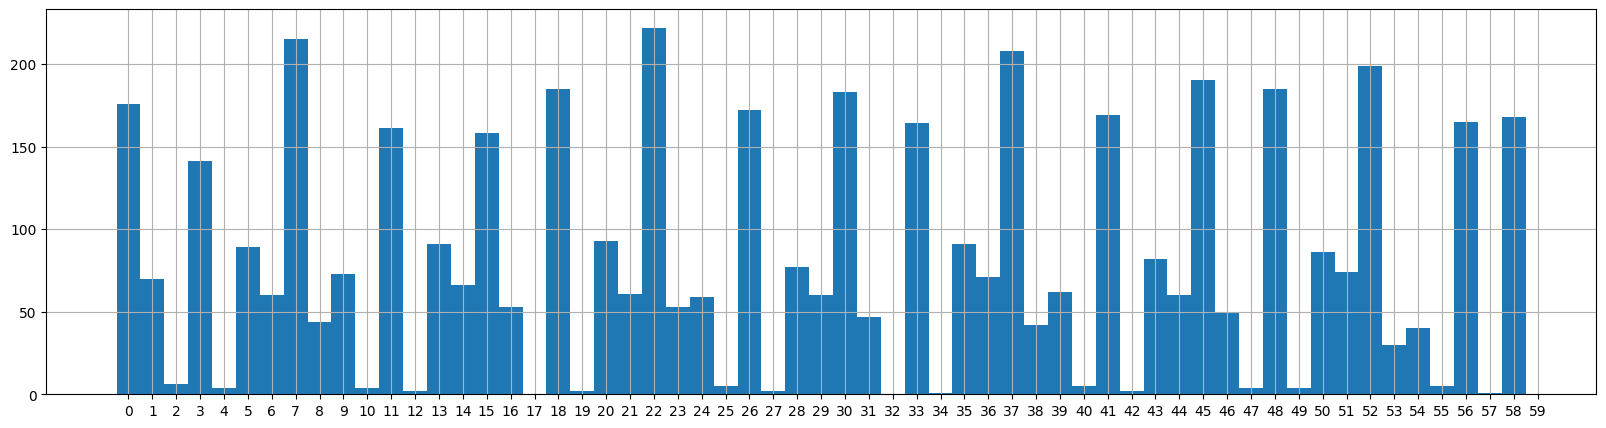

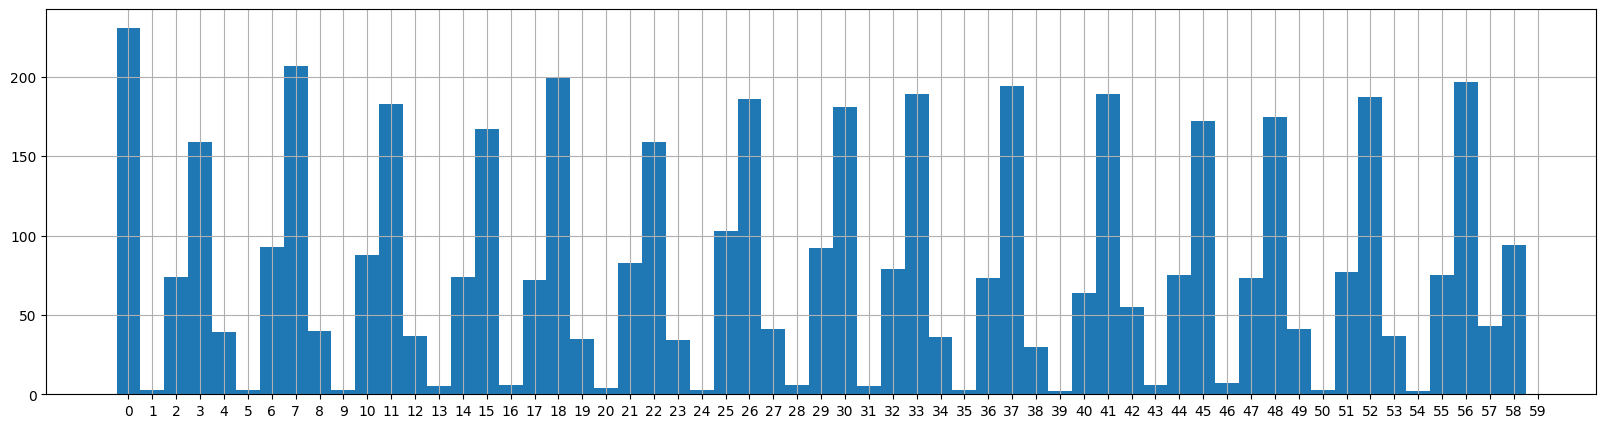

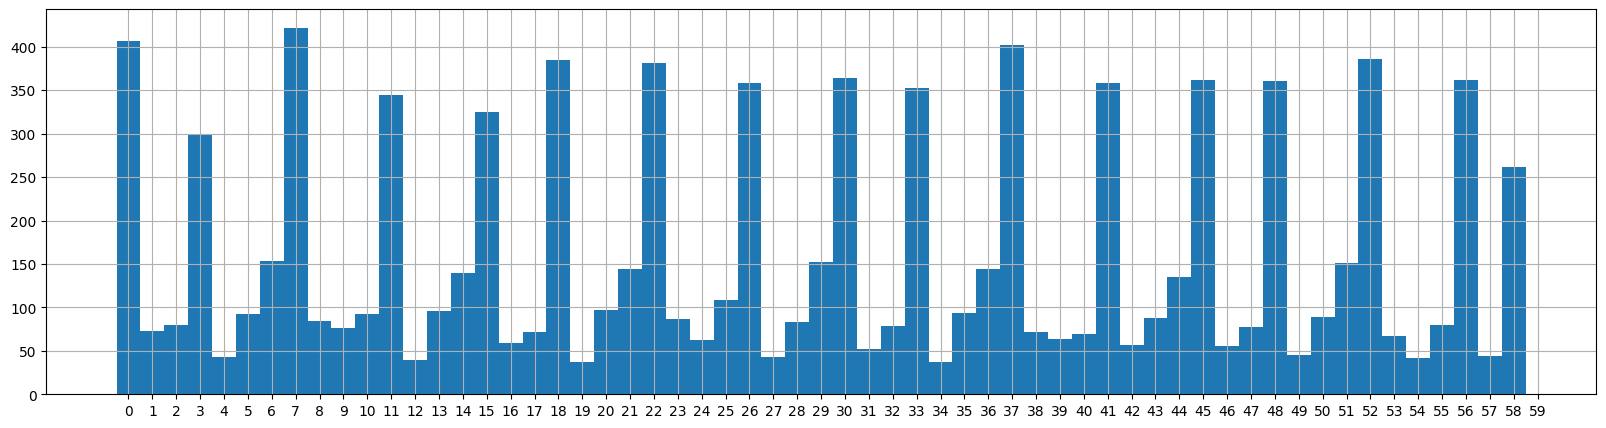

In [5]:
# 就寝する分
df = labels[labels["event"]=="onset"]
minutes = df["timestamp"].str[-10:-8].astype(int)
plt.subplots(figsize=(20, 5))
plt.hist(minutes, bins=range(60), align="left")
plt.xticks(np.arange(0, 60, 1))
plt.grid()
plt.show()

# 起床する分
df = labels[labels["event"]=="wakeup"]
minutes = df["timestamp"].str[-10:-8].astype(int)
plt.subplots(figsize=(20, 5))
plt.hist(minutes, bins=range(60), align="left")
plt.xticks(np.arange(0, 60, 1))
plt.grid()
plt.show()

# 全体
df = labels
minutes = df["timestamp"].str[-10:-8].astype(int)
plt.subplots(figsize=(20, 5))
plt.hist(minutes, bins=range(60), align="left")
plt.xticks(np.arange(0, 60, 1))
plt.grid()
plt.show()

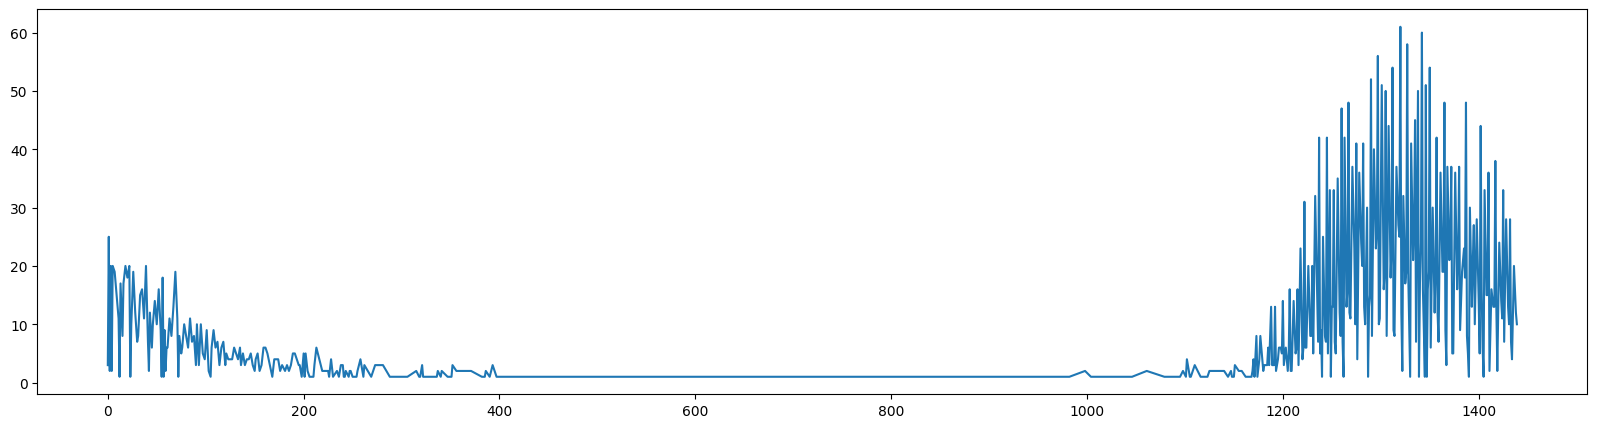

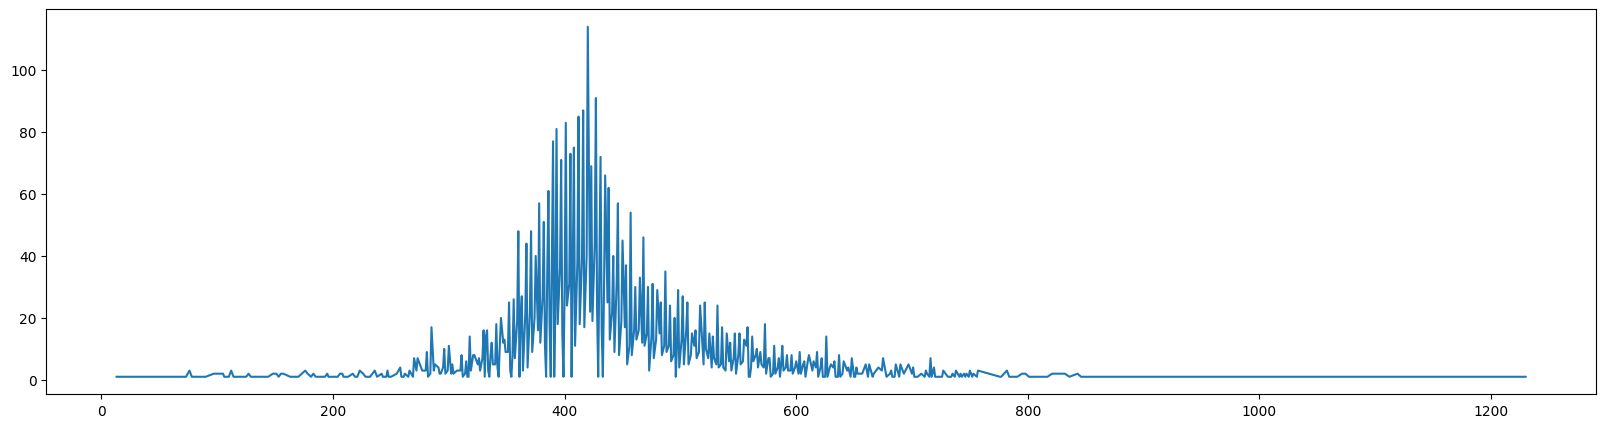

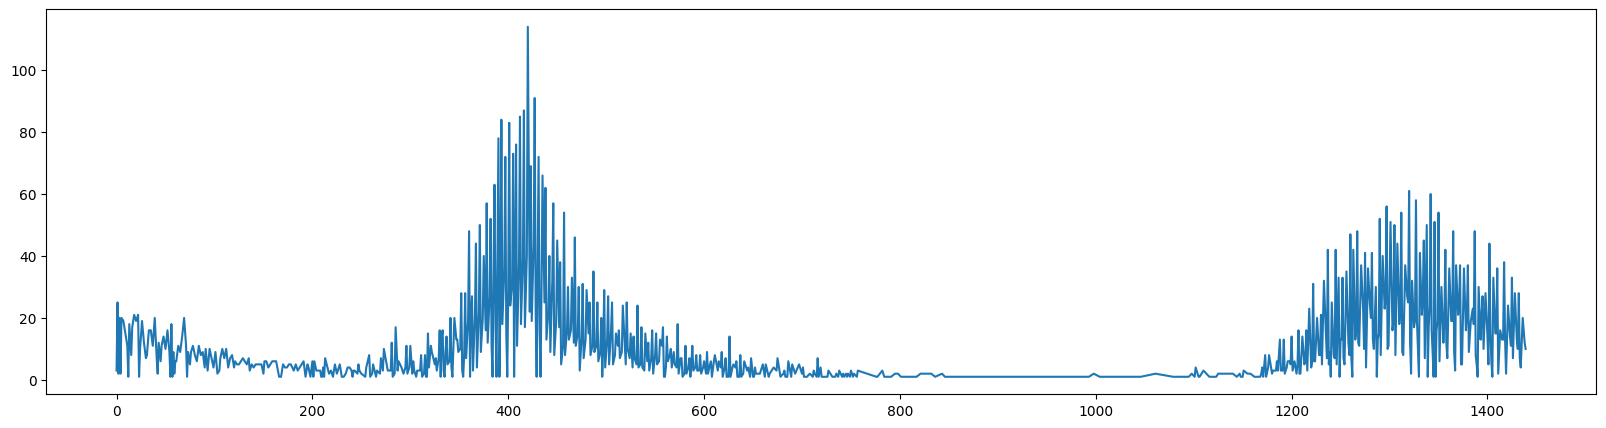

In [6]:
# 就寝する分
df = labels[labels["event"]=="onset"]
minutes = df["timestamp"].str[-10 - 3:-8 - 3].astype(int) * 60 + df["timestamp"].str[-10:-8].astype(int)
x = minutes.value_counts().sort_index().index
y = minutes.value_counts().sort_index().values
plt.subplots(figsize=(20, 5))
plt.plot(x, y)
plt.show()

# 起床する分
df = labels[labels["event"]=="wakeup"]
minutes = df["timestamp"].str[-10 - 3:-8 - 3].astype(int) * 60 + df["timestamp"].str[-10:-8].astype(int)
x = minutes.value_counts().sort_index().index
y = minutes.value_counts().sort_index().values
plt.subplots(figsize=(20, 5))
plt.plot(x, y)
plt.show()

# 全体
df = labels
minutes = df["timestamp"].str[-10 - 3:-8 - 3].astype(int) * 60 + df["timestamp"].str[-10:-8].astype(int)
x = minutes.value_counts().sort_index().index
y = minutes.value_counts().sort_index().values
plt.subplots(figsize=(20, 5))
plt.plot(x, y)
plt.show()

In [7]:
labels["timestamp"].str[-4:].value_counts()

0400    5542
0500    4043
Name: timestamp, dtype: int64

In [8]:
labels["timestamp"].str[-7:-5].value_counts()

00    9585
Name: timestamp, dtype: int64

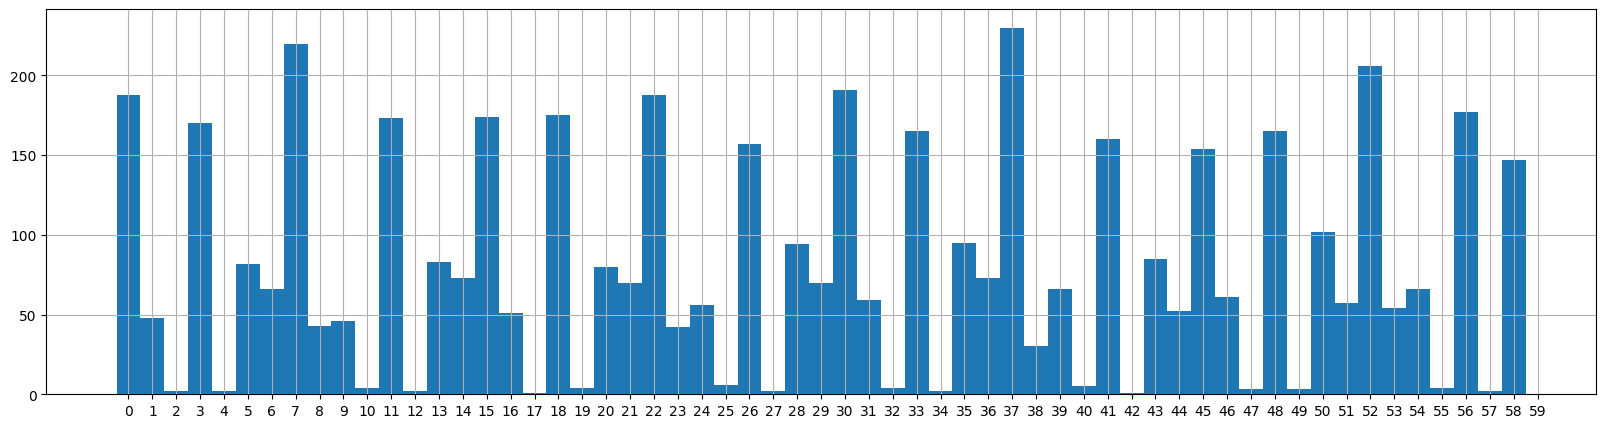

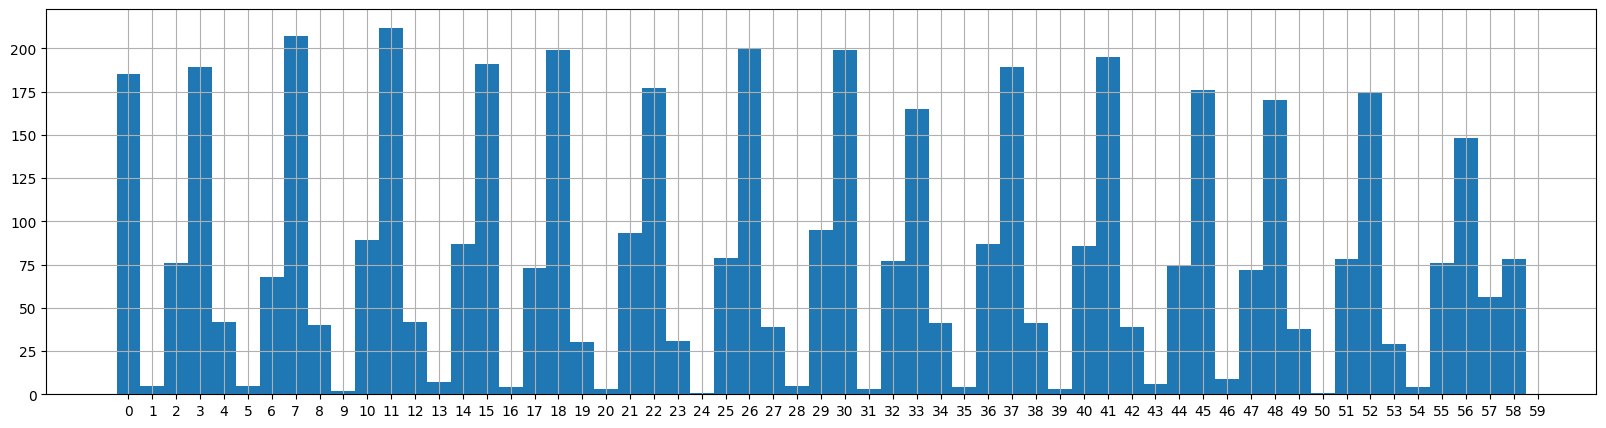

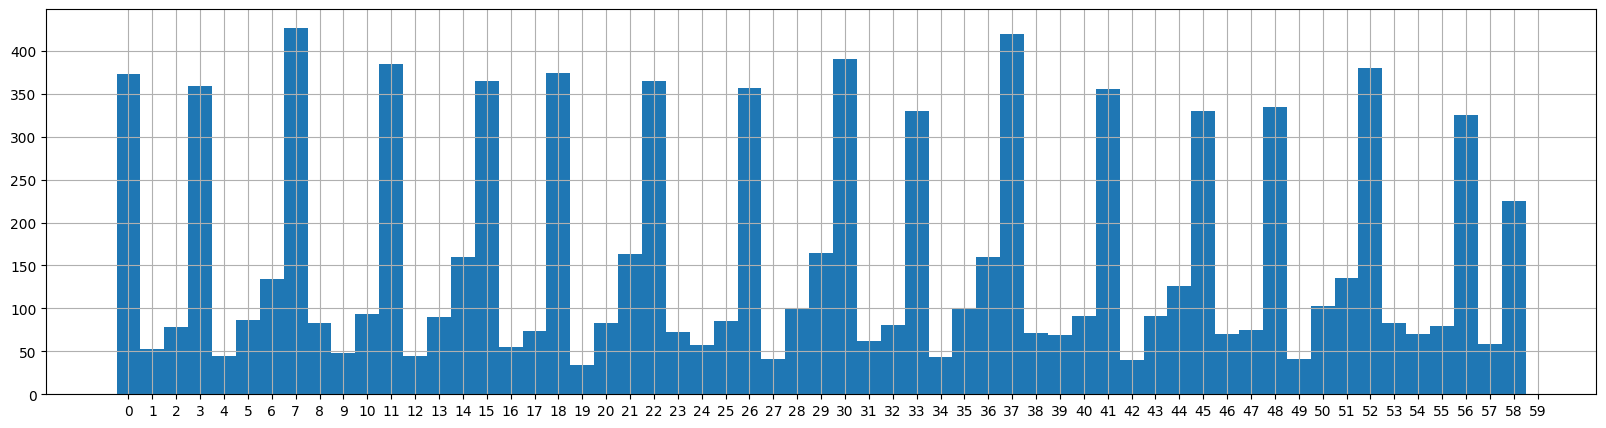

In [9]:
# 就寝する分
df = labels[labels["event"]=="onset"]
minutes = ((df["step"] // 12) % 60).astype(int)
plt.subplots(figsize=(20, 5))
plt.hist(minutes, bins=range(60), align="left")
plt.xticks(np.arange(0, 60, 1))
plt.grid()
plt.show()

# 起床する分
df = labels[labels["event"]=="wakeup"]
minutes = ((df["step"] // 12) % 60).astype(int)
plt.subplots(figsize=(20, 5))
plt.hist(minutes, bins=range(60), align="left")
plt.xticks(np.arange(0, 60, 1))
plt.grid()
plt.show()

# 全体
df = labels
minutes = ((df["step"] // 12) % 60).astype(int)
plt.subplots(figsize=(20, 5))
plt.hist(minutes, bins=range(60), align="left")
plt.xticks(np.arange(0, 60, 1))
plt.grid()
plt.show()

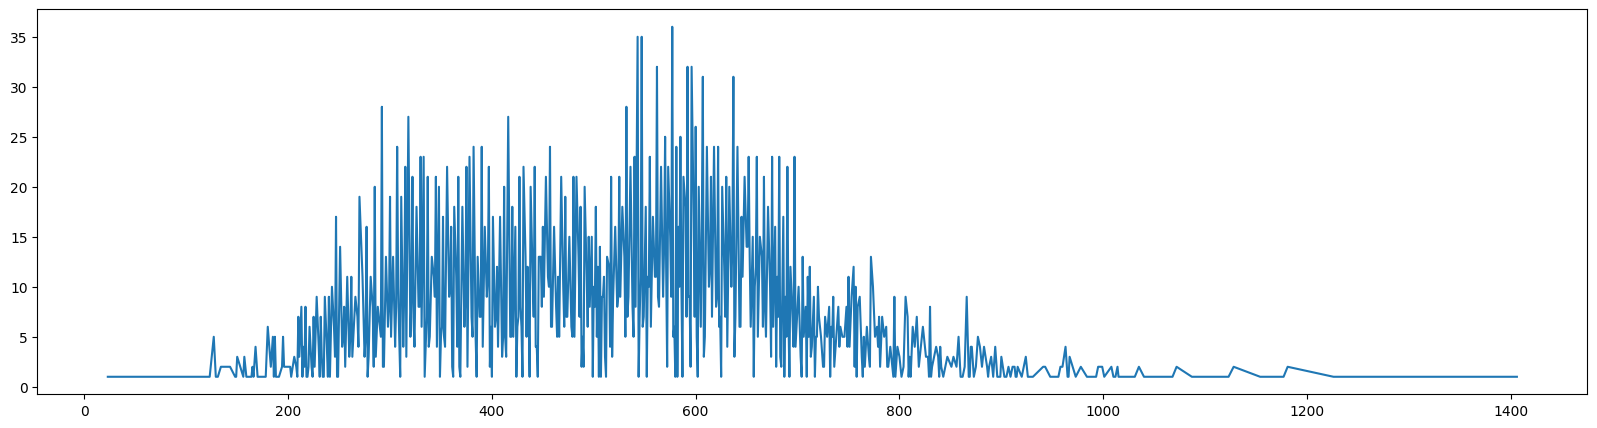

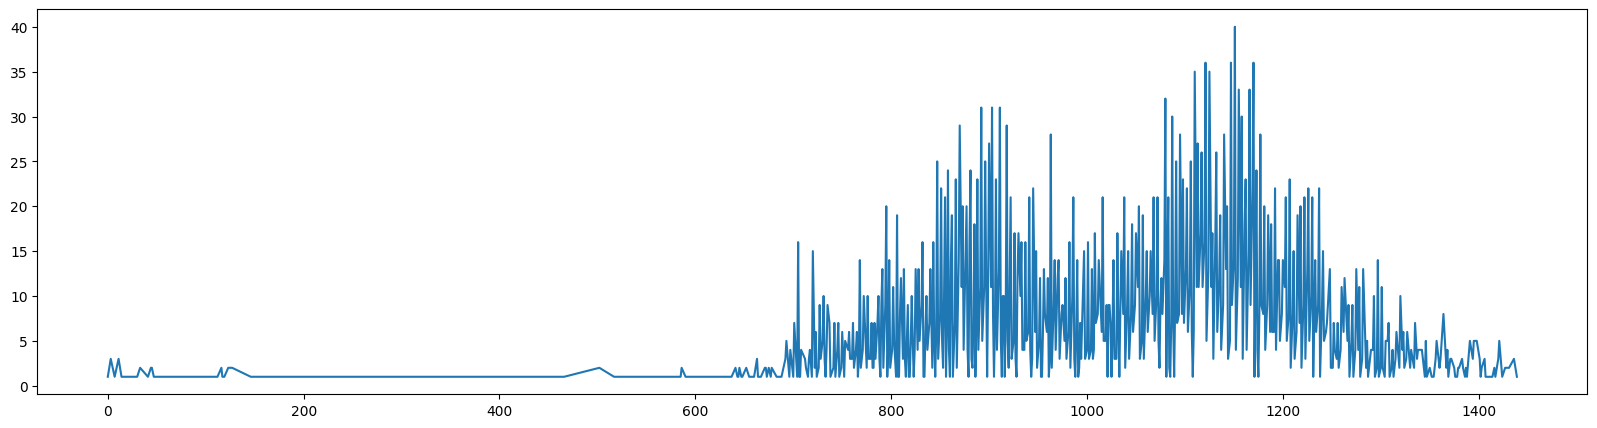

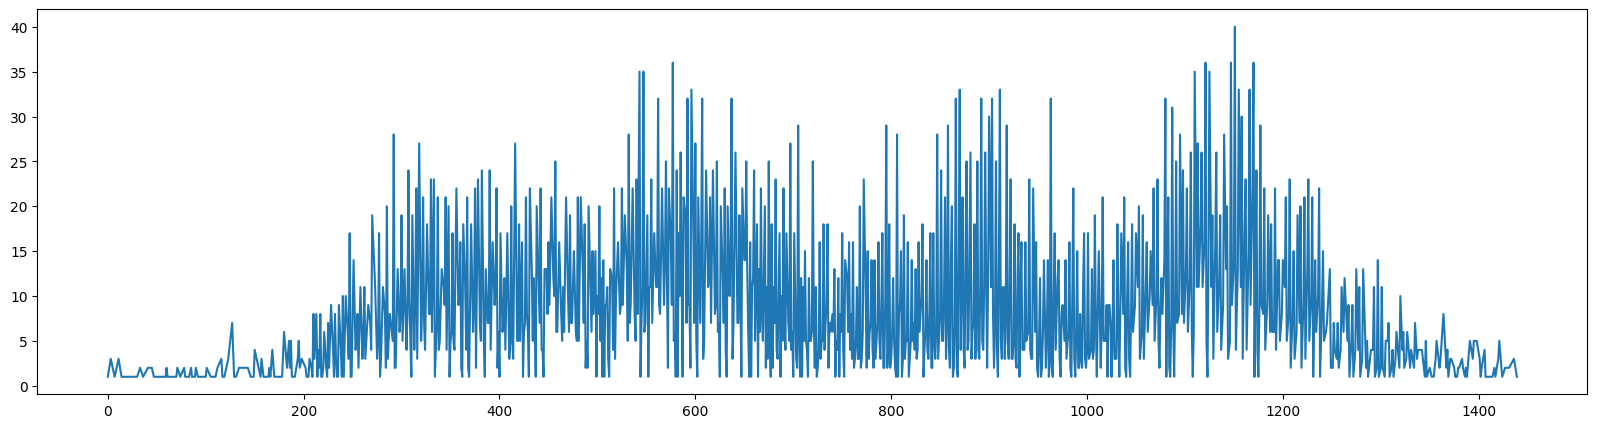

In [10]:
# 就寝する分
df = labels[labels["event"]=="onset"]
minutes = ((df["step"] // 12) % (60 * 24)).astype(int)
x = minutes.value_counts().sort_index().index
y = minutes.value_counts().sort_index().values
plt.subplots(figsize=(20, 5))
plt.plot(x, y)
plt.show()

# 起床する分
df = labels[labels["event"]=="wakeup"]
minutes = ((df["step"] // 12) % (60 * 24)).astype(int)
x = minutes.value_counts().sort_index().index
y = minutes.value_counts().sort_index().values
plt.subplots(figsize=(20, 5))
plt.plot(x, y)
plt.show()

# 全体
df = labels
minutes = ((df["step"] // 12) % (60 * 24)).astype(int)
x = minutes.value_counts().sort_index().index
y = minutes.value_counts().sort_index().values
plt.subplots(figsize=(20, 5))
plt.plot(x, y)
plt.show()

In [11]:
labels["minutes"] = labels["timestamp"].str[-10:-8].astype(int)
labels["minutes_step"] = ((labels["step"] // 12) % 60).astype(int)

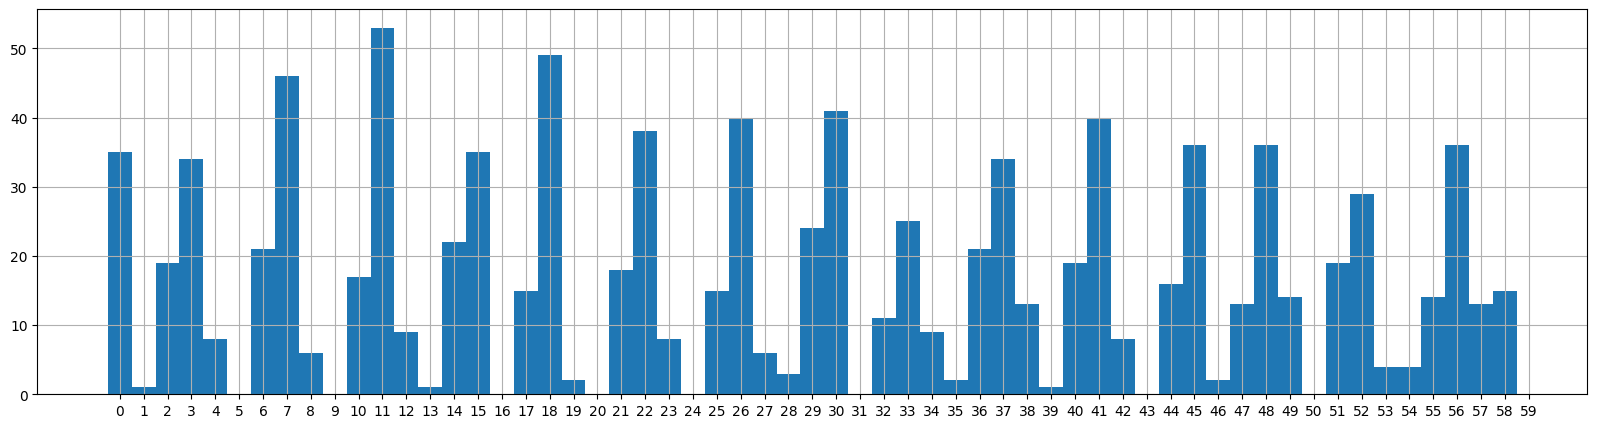

In [17]:
labels = labels.sort_values("step").reset_index(drop=True)

# 起床する分
df = labels[labels["event"]=="wakeup"].head(1000)
plt.subplots(figsize=(20, 5))
plt.hist(df["minutes_step"], bins=range(60), align="left")
plt.xticks(np.arange(0, 60, 1))
plt.grid()
plt.show()

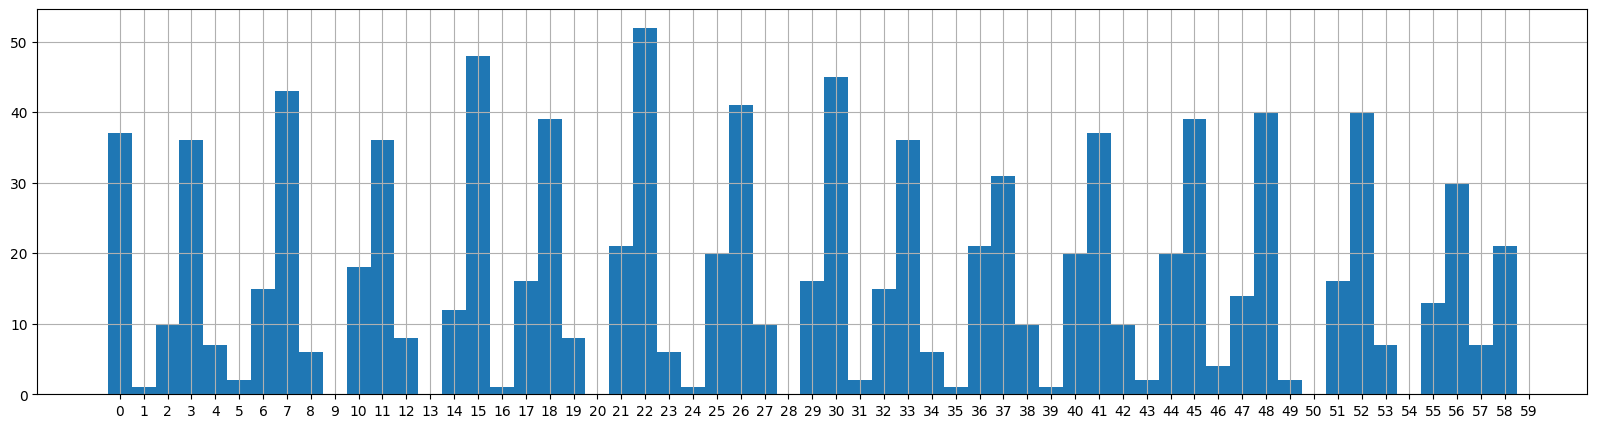

In [18]:
labels = labels.sort_values("step").reset_index(drop=True)

# 起床する分
df = labels[labels["event"]=="wakeup"].tail(1000)
plt.subplots(figsize=(20, 5))
plt.hist(df["minutes_step"], bins=range(60), align="left")
plt.xticks(np.arange(0, 60, 1))
plt.grid()
plt.show()

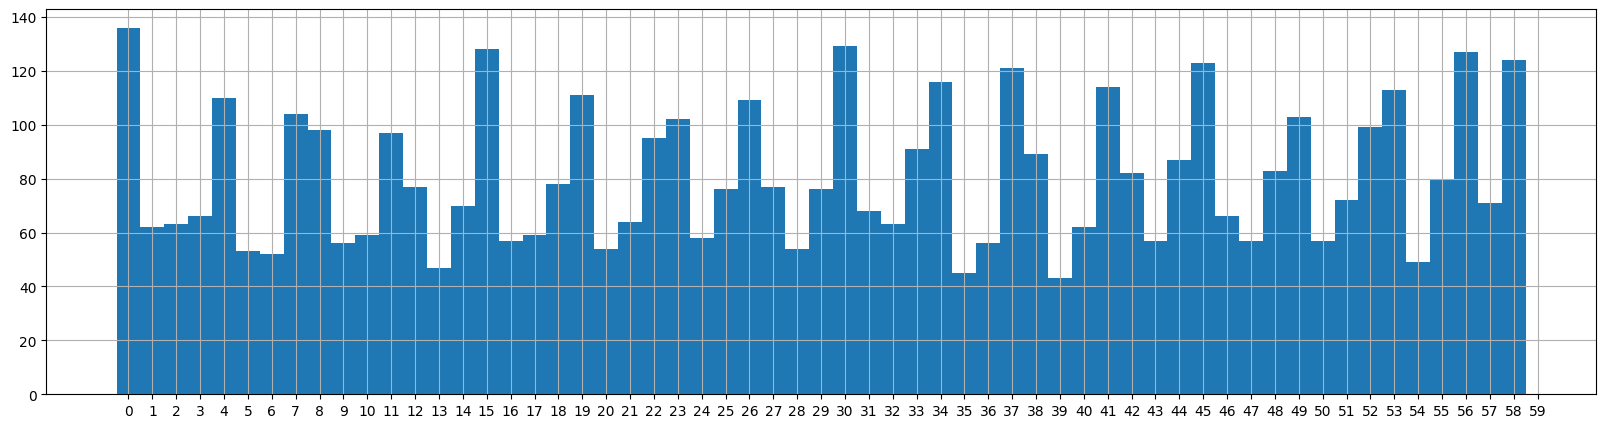

In [25]:
minutes = ((labels.groupby(["series_id", "night"])["step"].max() - labels.groupby(["series_id", "night"])["step"].min()).values / 12) % 60
plt.subplots(figsize=(20, 5))
plt.hist(minutes, bins=range(60), align="left")
plt.xticks(np.arange(0, 60, 1))
plt.grid()
plt.show()

In [29]:
df = labels[labels["event"]=="wakeup"]

edges = []
for _, sdf in df.groupby("series_id"):
    steps = sdf["minutes_step"].values
    for i in range(len(steps) - 1):
        edges.append([steps[i + 1], steps[i]])

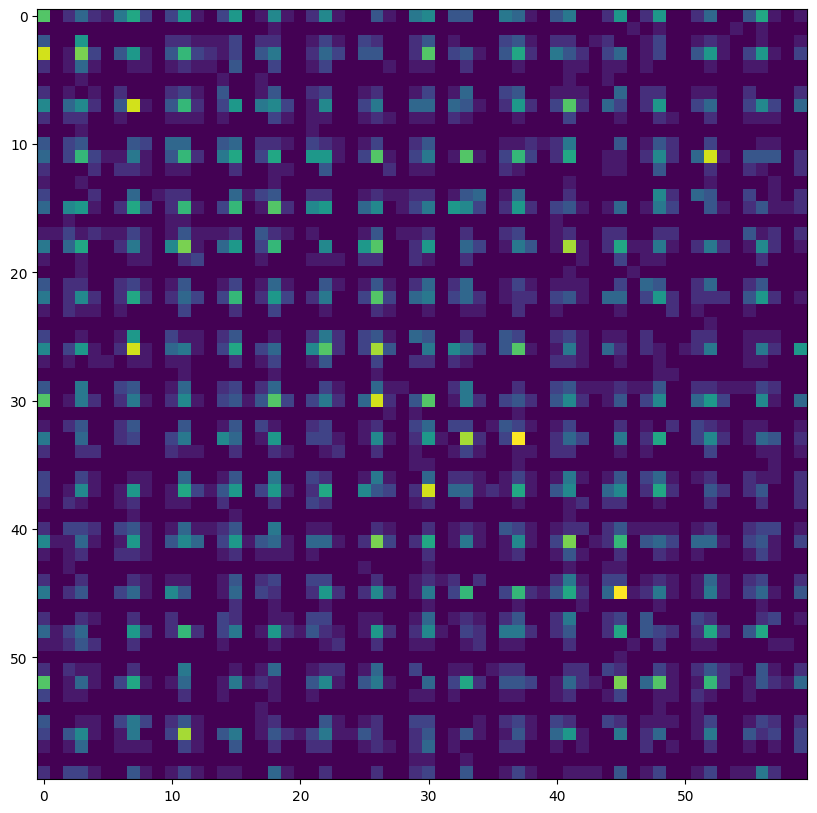

In [34]:
count = np.zeros((60, 60))
for i, j in edges:
    count[i, j] += 1

plt.subplots(figsize=(10, 10))
plt.imshow(count)
